# Movielens
---
Esta base de datos contiene información sobre películas y ratings de distintos usuarios.
Responde a las siguientes preguntas

# Carlos K. Delgado & Robert Cristea

In [1]:
!pip install ipython-sql

  Running setup.py bdist_wheel for prettytable ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/b6/90/7b/1c22b89217d0eba6d5f406e562365ebee804f0d4595b2bdbcd
Successfully built prettytable


**Cargamos la base de datos ** 

In [2]:
%load_ext sql
%sql sqlite:///data/movies/movielens.sqlite
%sql SELECT name FROM sqlite_master WHERE type='table'

Done.


name
ratings
links
tags
movies


Antes de empezar, recuerda que para ejecutar una query sql en las celdas de los notebooks, debes empezar la celda por `%%sql`. Por ejemplo...

In [3]:
%%sql

SELECT count() as num_rows
FROM movies

Done.


num_rows
9125


In [4]:
%%sql
select * from ratings limit 1;

Done.


index,userId,movieId,rating,timestamp
0,1,31,2.5,2009-12-14 02:52:24


In [5]:
%%sql
select * from links limit 1;

Done.


index,movieId,imdbId,tmdbId
0,1,114709,862.0


In [6]:
%%sql
select * from tags limit 1;

Done.


index,userId,movieId,tag,timestamp
0,15,339,sandra 'boring' bullock,2006-01-29 12:29:30


In [7]:
%%sql
select * from movies limit 1;

Done.


index,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


Recuerda que también puedes realizar queries a la base de datos usango `pandas` y `sqlite3`

In [38]:
# Pues vamos allá, vamos a preparar el entorno para poder usar pandas y sqlite3
import pandas as pd
import sqlite3

%matplotlib inline

path = 'data/movies/movielens.sqlite'

conn = sqlite3.connect(path)

---
<div class="panel panel-success">
    <div class='panel-heading'>
    <h4>Empecemos</h4>
    </div>
    <div class='panel-body'>
    <p> Responde a las siguientes preguntas de la base de datos
    </div>
</div>

**1. Nombra las columnas de cada tabla en la base de datos e identifíca las *primary* y *foreign* keys **

Utilizaremos la funcionalidad PRAGMA table_info() para obtener información de cada tabla.
Solucion basada en el siguiente enlace https://goo.gl/EBXG6i

In [19]:
%%sql
PRAGMA table_info(movies);

Done.


cid,name,type,notnull,dflt_value,pk
0,index,INTEGER,0,None,0
1,movieId,INTEGER,0,None,0
2,title,TEXT,0,None,0
3,genres,TEXT,0,None,0


La tabla MOVIES contine la primary key movieId

In [21]:
%%sql 
PRAGMA table_info(ratings);

Done.


cid,name,type,notnull,dflt_value,pk
0,index,INTEGER,0,None,0
1,userId,INTEGER,0,None,0
2,movieId,INTEGER,0,None,0
3,rating,REAL,0,None,0
4,timestamp,TIMESTAMP,0,None,0


La tabla RATINGS contine las foreign keys movieId y userId

In [22]:
%%sql
PRAGMA table_info(links);

Done.


cid,name,type,notnull,dflt_value,pk
0,index,INTEGER,0,None,0
1,movieId,INTEGER,0,None,0
2,imdbId,INTEGER,0,None,0
3,tmdbId,REAL,0,None,0


La tabla LINKS contiene las foreign keys movieId, imdbId y tmdbId

In [23]:
%%sql
PRAGMA table_info(tags);

Done.


cid,name,type,notnull,dflt_value,pk
0,index,INTEGER,0,None,0
1,userId,INTEGER,0,None,0
2,movieId,INTEGER,0,None,0
3,tag,TEXT,0,None,0
4,timestamp,TIMESTAMP,0,None,0


La tabla TAGS contiene las foreing keys userId y movieId

**2. ¿Cómo evolucion el rating de '12 Angry Men' a lo largo de los años? Haz un gráfico de la evolución**

In [43]:
# vamos a seleccionar una media de los ratings agrupados por años y ordenados de menor a mayor año
query = """
select strftime('%Y',r.timestamp) as year, avg(r.rating) as rating from ratings as r
inner join movies as m
on r.movieId = m.movieId
where m.title like '12 Angry Men%'
group by strftime('%Y',r.timestamp)
order by strftime('%Y',r.timestamp);
"""
df = pd.read_sql(query, conn)
df

,year,rating
0,1996,4.000000
1,1997,4.400000
2,1998,3.500000
3,1999,4.500000
4,2000,4.545455
5,2001,4.500000
6,2002,3.750000
7,2003,3.500000
8,2004,3.000000
9,2005,4.500000


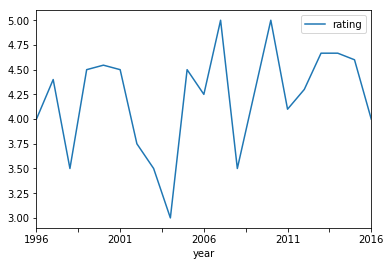

In [44]:
df = df.set_index(df['year'])
df = df.drop('year', axis = 1)
df.plot()

** 3. ¿Cuál es la película peor valorada de cada año? **

In [71]:
# Query que devuelve todos los años distintos de la tabla RATING

query_years = """SELECT DISTINCT strftime('%Y',timestamp) as year FROM ratings ORDER BY year ASC"""
years_unique = pd.read_sql(query_years, conn)

list_df = []

# para todos los años de rating vamos sacando la pelicula con la media de rating mas baja
for year in years_unique['year'].values:
    query = """
            SELECT m.title, strftime('%Y',r.timestamp) as year, AVG(r.rating) as avg_rating
            FROM ratings as r
            INNER JOIN movies as m
            ON r.movieId = m.movieId
            WHERE strftime('%Y',r.timestamp)=:y
            GROUP BY m.title, strftime('%Y',r.timestamp)
            ORDER BY avg_rating ASC
            LIMIT 1;
            """
    df = pd.read_sql(query, conn,params={'y':year})
    list_df.append(df)

df_all = pd.concat(list_df)

In [72]:
df_all

,title,year,avg_rating
0,"Fish Called Wanda, A (1988)",1995,3.0
0,Barb Wire (1996),1996,1.0
0,Airheads (1994),1997,1.0
0,American Buffalo (1996),1998,1.0
0,"Adventures of Elmo in Grouchland, The (1999)",1999,1.0
0,102 Dalmatians (2000),2000,1.0
0,"6th Man, The (Sixth Man, The) (1997)",2001,1.0
0,2 ou 3 choses que je sais d'elle (2 or 3 Thing...,2002,1.0
0,"Angel at My Table, An (1990)",2003,0.5
0,13 Ghosts (1960),2004,0.5


** 4. ¿Quién es el usuario más activo y desde cuándo lleva activo? **

In [73]:
%%sql

SELECT userId, COUNT(userId) AS numero_veces
FROM ratings
GROUP BY userId
ORDER BY numero_veces DESC
LIMIT    1;

Done.


userId,numero_veces
547,2391


El usuario mas activo es el del ID 547 con 2391 valoraciones

In [43]:
%%sql

SELECT timestamp
FROM ratings 
WHERE userId = '547'
ORDER BY timestamp ASC
LIMIT 1;

Done.


timestamp
2000-11-21 03:25:09


Suponemos que el usuario con ID 547 lleva activo desde el 21 de Noviembre del año 2000, fecha de su primera valoración.

** 5. ¿Cuales son sus 5 películas favorítas del año 2016? **

La pregunta es ambigua. Por ello vamos a sacar dos posibles respuestas:

a) Las 5 peliculas mejor puntuadas en el año 2016 por el usuario con ID 547.

In [79]:
%%sql

SELECT m.title, r.rating
FROM ratings AS r
INNER JOIN movies AS m
ON r.movieId = m.movieId
WHERE strftime('%Y',r.timestamp) = '2016'
AND r.userId = '547'
ORDER BY r.rating desc
LIMIT 5;

Done.


title,rating
Making a Murderer (2015),5.0
The Beatles: Eight Days a Week - The Touring Years (2016),5.0
"Lust, Caution (Se, jie) (2007)",4.5
"Impossible, The (Imposible, Lo) (2012)",4.5
Ex Machina (2015),4.5


b) Las 5 peliculas del año 2016 con mas puntuacion por parte del usuario con ID 547.

In [88]:
%%sql

SELECT m.title, r.rating
FROM ratings AS r
INNER JOIN movies AS m
ON r.movieId = m.movieId
WHERE title LIKE '%2016%'
AND r.userId = '547'
ORDER BY r.rating desc
LIMIT 5;

Done.


title,rating
The Beatles: Eight Days a Week - The Touring Years (2016),5.0
The Jungle Book (2016),4.0
Sing Street (2016),4.0
Piper (2016),4.0
10 Cloverfield Lane (2016),3.5


**6. Haz una gráfica de como evolucionan el número de películas que ve cada año y la nota media. **

In [83]:
query = """
SELECT strftime('%Y',timestamp) as year, COUNT(movieId) as numero_peliculas
FROM ratings
WHERE userId = '547'
GROUP BY strftime('%Y', timestamp)
ORDER BY strftime('%Y', timestamp);
"""
df = pd.read_sql(query, conn)
df

,year,numero_peliculas
0,2000,212
1,2001,240
2,2002,269
3,2003,301
4,2004,202
5,2005,193
6,2006,93
7,2007,153
8,2008,141
9,2009,95


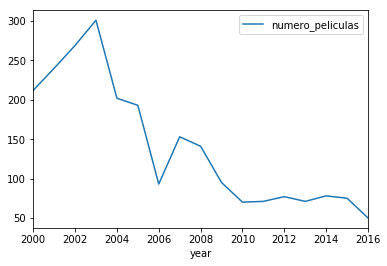

In [84]:
df = df.set_index(df['year'])
df = df.drop('year', axis = 1)
df.plot()

Podemos observar como la evolucion del numero de peliculas que ve cada año ha ido en descenso, teniendo su maximo en el año 2003.

In [86]:
query = """
SELECT strftime('%Y',timestamp) as year, AVG(rating) as nota_media
FROM ratings
WHERE userId = '547'
GROUP BY strftime('%Y', timestamp)
ORDER BY strftime('%Y', timestamp);
"""
df = pd.read_sql(query, conn)
df

,year,nota_media
0,2000,4.080189
1,2001,3.237500
2,2002,3.018587
3,2003,3.242525
4,2004,2.985149
5,2005,3.349741
6,2006,3.252688
7,2007,3.333333
8,2008,3.453901
9,2009,3.384211


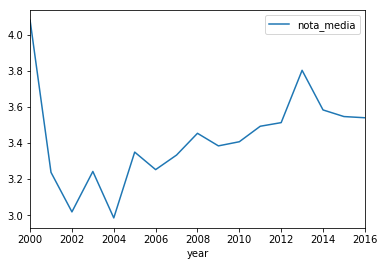

In [87]:
df = df.set_index(df['year'])
df = df.drop('year', axis = 1)
df.plot()

Podemos observar como la puntuación de las peliculas que ve cada año ha ido en aumento. Teniendo en cuenta este grafico junto al grafico anterior podemos llegar a una posible conclusión: el usuario con ID 547 ve menos peliculas pero de mas calidad.